<h1 style="color:#2192f1"> PARIS HOUSING PRICES PREDICTION</h1>


<h2> <span style="color:#12f095">GOAL : </span> Predict sales prices four each house using : <br><br> <span style="color:#7b55e1; font-style:oblique">Linear Regression<br>Decision Tree Regressor<br> Random Forest Regressor<br>XGBoost Regressor<br></span></h2>



<h2 style="color:#f0e912">IMPORTING LIBRARIES</h2>


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from tqdm import tqdm


from sklearn.inspection import PartialDependenceDisplay

from sklearn import preprocessing


<h2 style="color:#f0e912"><br>DATA EXPLORATION</h2>


In [2]:
# Load data
data = pd.read_csv("../data/ParisHousing.csv")

In [3]:
# Quick overview
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [4]:
# Give information about features ( Entries number, type, features number, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [5]:
# Divide data
X = data.drop('price', axis=1)
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style="color:#f0e912"><br>DATA VISUALIZATION</h2>


In [6]:
# Combine X_train and y_train for visualization
df_plot = X_train.copy()
df_plot['price'] = y_train

<Axes: >

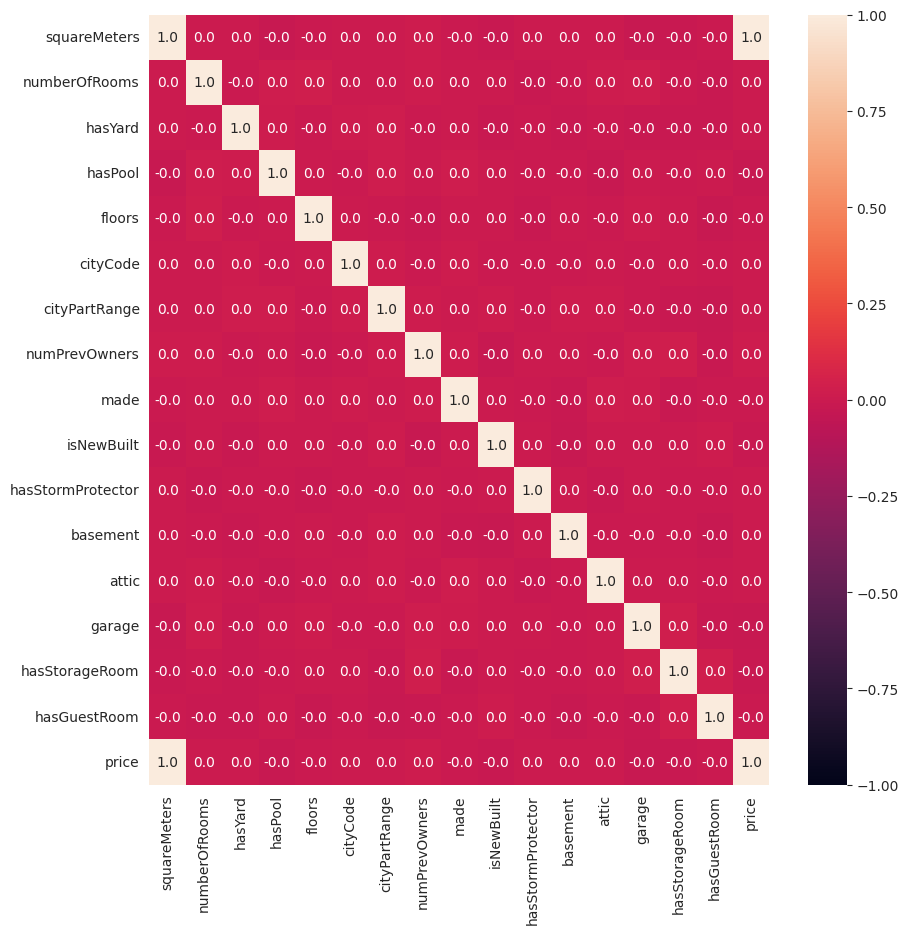

In [7]:
# matrix correlation
matrix = df_plot.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt='.1f', vmin=-1, vmax=1)

In [8]:
spearman_corr = df_plot.corr(method='spearman')
print(spearman_corr['price'])

squareMeters         0.999999
numberOfRooms        0.006316
hasYard              0.004955
hasPool             -0.017299
floors              -0.002080
cityCode             0.001969
cityPartRange        0.007477
numPrevOwners        0.014775
made                -0.006750
isNewBuilt          -0.009556
hasStormProtector    0.004627
basement             0.000695
attic                0.000994
garage              -0.017664
hasStorageRoom      -0.011758
hasGuestRoom        -0.000337
price                1.000000
Name: price, dtype: float64


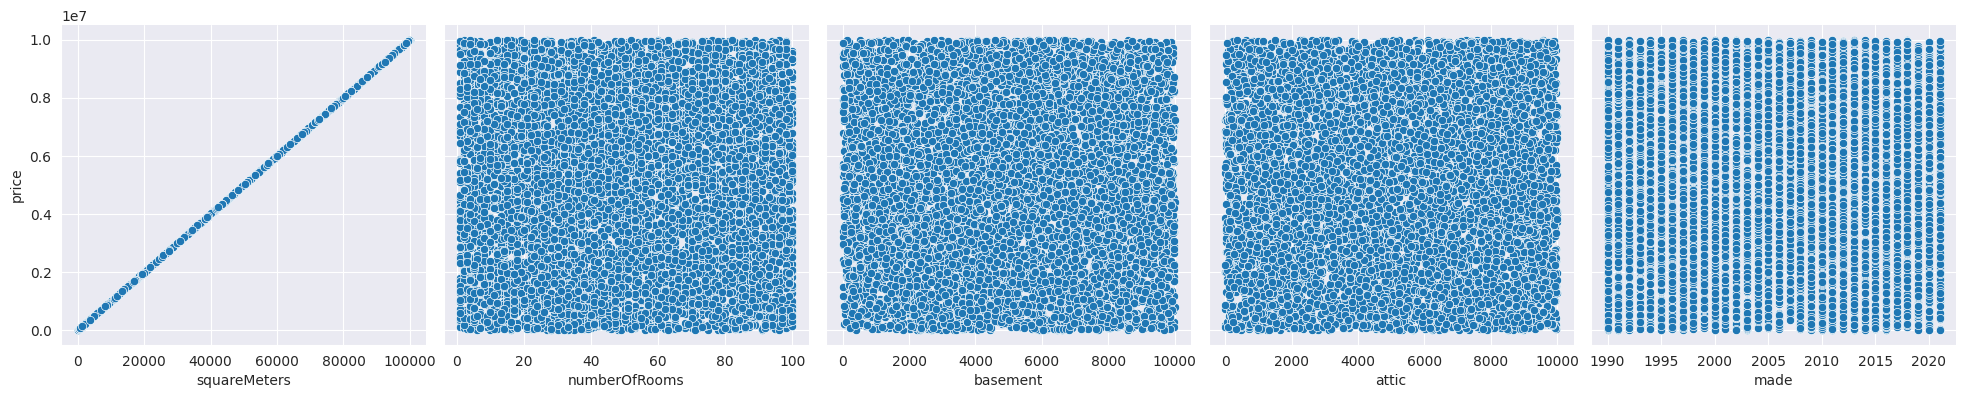

In [9]:
sns.pairplot(
    df_plot,
    x_vars=['squareMeters', 'numberOfRooms', 'basement', 'attic', 'made'],
    y_vars='price',
    height=4,
    aspect=1
)

<h2 style="color:#f0e912"><br>MODEL TRAINING</h2>


<h3 style="color:#0c99d1">LINEAR REGRESSION</h3>

In [10]:
model = LinearRegression()

In [11]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
y_pred = model.predict(X_test)

In [13]:
# evaluation
# model evaluation
print(
    'mean_squared_error : ', mean_squared_error(y_test, y_pred))
print(
    'mean_absolute_error : ', mean_absolute_error(y_test, y_pred))

mean_squared_error :  3695708.440619091
mean_absolute_error :  1510.0341808542296


In [14]:
# Residuals distribution
def residuals_distribution(y_test, y_pred):
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


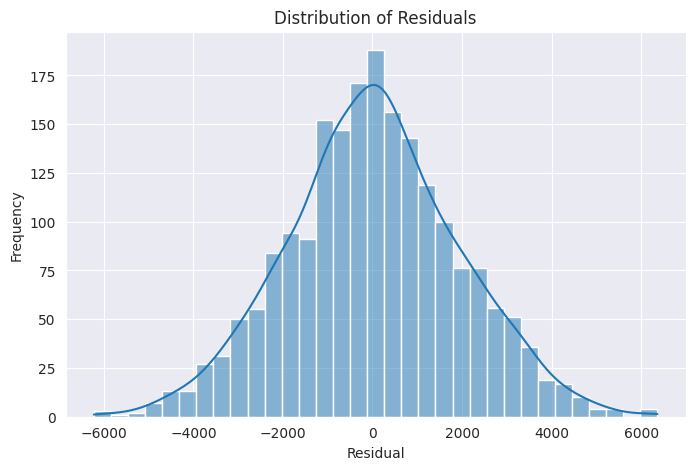

In [15]:
residuals_distribution(y_test, y_pred)

<h3 style="color:#0c99d1">DECISION TREE REGRESSOR</h3>


<h4 style="color:#e8b215">SIMPLE SETTING</h4>


In [16]:
# Model definition
regressor = DecisionTreeRegressor(random_state=42)

In [17]:
# Cross-validation to test the robustness of the model and its ability to generalize to new data
cross_val_score(regressor, X_train, y_train, cv=10)

array([0.99999617, 0.99999571, 0.99999658, 0.99999572, 0.99999589,
       0.99999633, 0.99999626, 0.99999627, 0.99999585, 0.9999963 ])

In [18]:
regressor.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [19]:
y_pred_tree = regressor.predict(X_test)

In [20]:
# R2 score
regressor.score(X_test, y_test)

0.9999962852761607

In [21]:
# evaluation
# model evaluation
print(
    'mean_squared_error : ', mean_squared_error(y_test, y_pred_tree))
print(
    'mean_absolute_error : ', mean_absolute_error(y_test, y_pred_tree))

mean_squared_error :  32536359.86294506
mean_absolute_error :  4494.983150000007


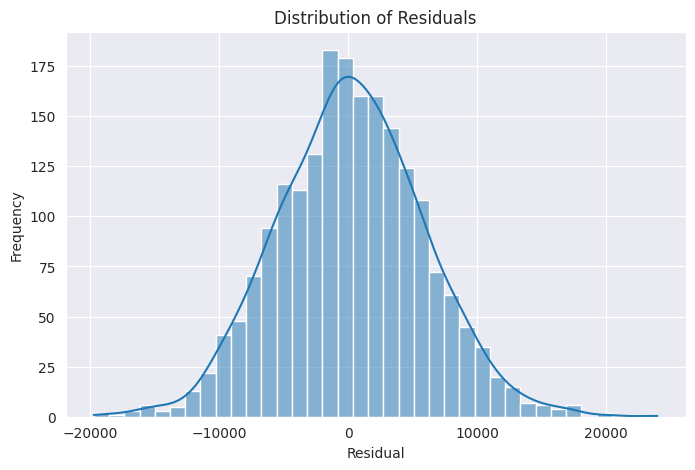

In [22]:
residuals_distribution(y_test, y_pred_tree)

<h4 style="color:#e8b215">GRID SEARCH</h4>


In [39]:
# Dictionary of parameters to test
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 8, 10, 12, 17,  20],
    'min_samples_split': [2, 5, 10, 15, 30, 45, 50, 70],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': [None,  'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

In [ ]:
from sklearn.model_selection import ParameterGrid

best_score = float('inf')
best_params = None

grid = ParameterGrid(param_grid)

for params in tqdm(grid, desc="Grid Search"):
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)

    if score < best_score:
        best_score = score
        best_params = params

Grid Search:   0%|          | 14/6048 [00:00<05:01, 20.00it/s]

In [41]:
print("\nBest MSE:", best_score)
print("Best params:", best_params)


Best MSE: 25892180.18763301
Best params: {'ccp_alpha': 0.01, 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}


In [42]:
final_model = DecisionTreeRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.01


In [43]:
y_pred_gridsearch = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_gridsearch)
print("Test MSE:", test_mse)

Test MSE: 25985894.52007718


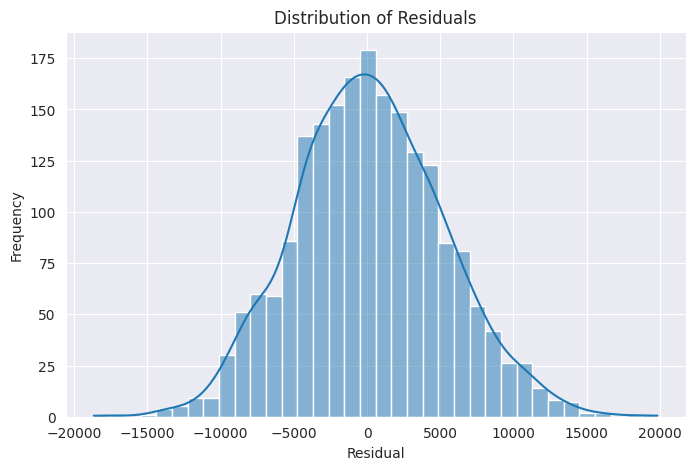

In [44]:
residuals_distribution(y_test, y_pred_gridsearch)